In [141]:
import sklearn
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import joblib
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

def evaluate_model(y_test, y_pred):
    print("Mean absolute error:\t", int(mean_absolute_error(y_test, y_pred)))
    print("Mean squared error:\t", int(mean_squared_error(y_test, y_pred)))

In [154]:
conn = sqlite3.connect('../db.sqlite3')
df_raw = pd.read_sql_query('''
SELECT "bouwjaar", "kilometer_stand", "vermogen", "prijs", "is_handgeschakeld", "is_benzine", "titel" 
FROM scraper_auto  
WHERE prijs < 15000
''', conn)
df = df_raw.dropna()
df.describe()

,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine
count,1201.00000,1.201000e+03,1201.000000,1201.000000,1201.000000,1201.000000
mean,2009.80433,1.673047e+05,83.735221,3655.383014,0.976686,0.574521
std,2.88863,9.653735e+04,13.467795,2278.789858,0.150961,0.494621
min,2005.00000,7.183000e+03,51.000000,1.000000,0.000000,0.000000
25%,2007.00000,1.181140e+05,77.000000,2295.000000,1.000000,0.000000
50%,2010.00000,1.710000e+05,84.000000,2950.000000,1.000000,1.000000
75%,2011.00000,2.100000e+05,86.000000,4240.000000,1.000000,1.000000
max,2018.00000,2.625966e+06,180.000000,13900.000000,1.000000,1.000000


In [155]:
df_train, df_test = train_test_split(df, test_size=0.2)

X_train = df_train.drop(['prijs'], axis=1)
y_train = df_train[['prijs']]

X_test = df_test.drop(['prijs'], axis=1)
y_test = df_test[['prijs']]['prijs']
X_test

,bouwjaar,kilometer_stand,vermogen,is_handgeschakeld,is_benzine,titel
1002,2014,252930.0,84,1.0,0,Fiat Punto Evo 1.3 M-Jet Dynamic Clima Elek Pa...
897,2014,85300.0,101,1.0,1,Fiat Punto Evo 0.9 TwinAir Young | AIRCO
1,2008,169504.0,78,0.0,1,Fiat Grande Punto 1.4-16V Emotion 5dr Automaat...
64,2006,228803.0,51,1.0,0,Fiat Grande Punto 1.4 CNG-ARDGAS AIRCO 5DEURS ...
606,2010,244651.0,84,1.0,0,Fiat Punto Evo1.3 M-Jet Dynamic / Airco / Crui...
...,...,...,...,...,...,...
419,2018,32726.0,99,1.0,1,Fiat Punto Turbo 100pk 5d Sempre|PARKEERSENSOR...
1138,2009,113290.0,78,1.0,1,Fiat Grande Punto 1.4 Active
446,2014,104896.0,101,1.0,1,Fiat Punto Evo 5drs. 0.9 TwinAir Street | Airco |
766,2007,195185.0,65,1.0,1,Fiat Grande Punto 1.2 Active 5-deurs Airco Stu...


In [156]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, ['bouwjaar', "kilometer_stand", "vermogen"]),
        ('text',  CountVectorizer(), 'titel')
    ],
    remainder='passthrough')

In [157]:
pipelines = []
pipelines.append(('DecisionTreeRegressor      ', Pipeline([('preprocessor', preprocessor),('LR', DecisionTreeRegressor())])))
pipelines.append(('Lasso                      ', Pipeline([('preprocessor', preprocessor),('LASSO', Lasso())])))
pipelines.append(('ElasticNet                 ', Pipeline([('preprocessor', preprocessor),('EN', ElasticNet())])))
pipelines.append(('KNeighborsRegressor        ', Pipeline([('preprocessor', preprocessor),('KNN', KNeighborsRegressor())])))
pipelines.append(('DecisionTreeRegressor      ', Pipeline([('preprocessor', preprocessor),('CART', DecisionTreeRegressor())])))
pipelines.append(('GradientBoostingRegressor  ', Pipeline([('preprocessor', preprocessor),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %i (%i)" % (name, abs(cv_results.mean()), cv_results.std())
    print(msg)

DecisionTreeRegressor      : 630 (40)
Lasso                      : 546 (55)
ElasticNet                 : 689 (97)
KNeighborsRegressor        : 611 (55)
DecisionTreeRegressor      : 613 (34)
GradientBoostingRegressor  : 504 (62)


In [158]:
param_grid = {
#     'preprocessor__numeric__imputer__strategy': ['mean', 'median', 'constant'],
    'preprocessor__text__ngram_range': [(1,2)],
    'classifier__loss': ['ls', 'lad', 'huber', 'quantile'],
    'classifier__learning_rate': np.arange(0, 0.5, 0.1)
}

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingRegressor())
])

grid_search = GridSearchCV(clf, 
                           param_grid, 
                           cv=2,
                           scoring='neg_mean_absolute_error'
)

grid_search.fit(X_train, y_train)

print(("Best result: %.3f" % abs(grid_search.score(X_test, y_test))))

grid_search.best_params_

Best result: 459.092


{'classifier__learning_rate': 0.1,
 'classifier__loss': 'huber',
 'preprocessor__text__ngram_range': (1, 2)}

In [159]:
y_pred = grid_search.best_estimator_.predict(X_test)
evaluate_model(y_test, y_pred)

Mean absolute error:	 459
Mean squared error:	 403743


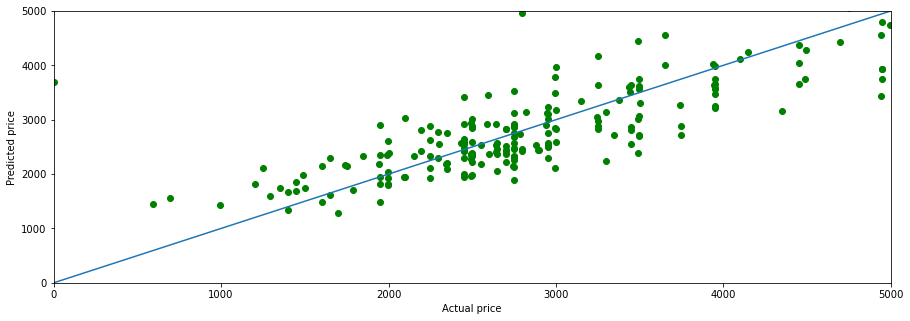

In [160]:
plt.figure(figsize=(15,5))
plt.scatter(y_test,y_pred,c='green')
plt.plot([0,5000], [0,5000])
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.xlim(0, 5000)
plt.ylim(0, 5000)
plt.show()

In [161]:
joblib.dump(grid_search.best_estimator_, 'Regressor')

['Regressor']